In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, accuracy_score
from os import listdir
from os.path import isfile, join


In [2]:
model_path = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'

embed = hub.Module(model_path, trainable=False)
messages = tf.placeholder(dtype=tf.string, shape=[None])
session = tf.Session()
session.run([tf.global_variables_initializer(), tf.tables_initializer()])
output = embed(messages)
def embed_sentences(sentences):
  vecs = session.run(output, feed_dict={messages: sentences})
  return vecs

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
'''read first 20k record of data'''
def load_datasets(file_path, fields):
    df = pd.read_csv(file_path, usecols=fields)
    return df

In [0]:
folder = '/gdrive/My Drive/playstore/reviews data/labeled/most relevent reviews/'
labeled_files_names = [folder + f for f in listdir(folder) if isfile(join(folder, f))]
folder = '/gdrive/My Drive/playstore/reviews data/labeled/old reviews/'
labeled_files_names += [folder + f for f in listdir(folder) if isfile(join(folder, f))]

folder = '/gdrive/My Drive/playstore/reviews data/unlabeled/'
unlabeled_files_names = [folder + f for f in listdir(folder) if isfile(join(folder, f))]

In [0]:
def get_app(file):
  if 'wta' in file:
    return 'whatsapp'
  elif 'msg' in file:
    return 'messenger'
  elif 'ins' in file:
    return 'instagram'
  elif 'fbk' in file:
    return 'facebook'
  return 'Unknown'

In [9]:
fields = ['text', 'label', 'up_votes']
df = pd.DataFrame(columns=fields)
for file in labeled_files_names:
  df1 = load_datasets(file, fields)
  app = get_app(file)
  df1['app'] = app
  df = df.append(df1, ignore_index=True)    
  
  

df.up_votes = df.up_votes.fillna(0).astype(int)
df.label = df.label.fillna(7).astype(int)
df = df.sample(frac=1)
df['label'] = df['label'].replace([0], 7)
df['label'] = df['label'].astype(str)

print(len(df))
print('apps statistics ', df[df.app=='whatsapp'].label.value_counts())

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


5480
apps statistics  7    3552
2     472
1     301
3      99
6      49
4       6
5       1
Name: label, dtype: int64


In [10]:
from collections import Counter
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
import spacy
nltk.download('stopwords')
nlp = spacy.load('en')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
stop = stopwords.words('english')
extended_stop = stop + ['facebook', 'app','whatsapp','please', 'app', 'even', 'want', 'like', 'good', 'messenger', 'fix', 'problem', 'can\'t']
app_data = df[df['app']=='whatsapp']
category_data = app_data[app_data['label']=='2']
category_data['text'] = category_data['text'].apply(lambda x: " ".join(token.lower_ for token in nlp(x) if (not token.is_stop and not token.is_punct and not token.is_digit and token.lower_ not in extended_stop)) )
category_data_text = category_data['text'].tolist()
print(len(category_data))

4480


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
category_vecs = embed_sentences(category_data_text)

# One batche clustering

# Just for Suggestions

In [0]:

clusters_number = 5
kmeans = KMeans(n_clusters=clusters_number, random_state=0).fit(category_vecs)#,sample_weight=category_data['up_votes'].tolist())
category_data['cluster'] = pd.Series(kmeans.labels_, index=category_data.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


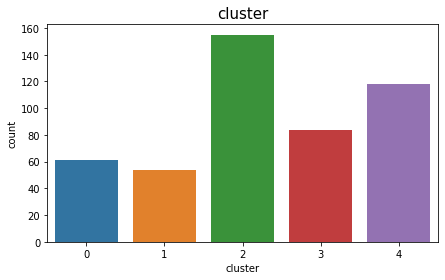

In [0]:
data = category_data.copy()
plt.figure(figsize=(7,4))
sns.countplot(data['cluster'].astype('str').sort_values())
plt.title("cluster",fontsize=15)
plt.show()

In [0]:
key_words = {}
category_data['text'] = category_data['text'].apply(lambda x: " ".join([item.lower() for item in x.split() if item.lower() not in extended_stop]))

for cluster in range(clusters_number):
  key_words[cluster] = Counter(" ".join(category_data[category_data['cluster']==cluster]["text"]).split()).most_common(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
for cluster, cluster_word in key_words.items():
  print(cluster, cluster_word)

0 [('mode', 21), ('dark', 19), ('feature', 17), ('update', 14), ('option', 13), ('message', 13)]
1 [('great', 10), ('people', 9), ('best', 8), ('thanks', 7), ('seen', 6), ('send', 5)]
2 [('status', 66), ('people', 66), ('option', 66), ('message', 58), ('feature', 50), ('group', 49)]
3 [('group', 83), ('chat', 36), ('option', 31), ('add', 24), ('feature', 22), ('groups', 16)]
4 [('video', 36), ('time', 31), ('status', 28), ('option', 26), ('update', 26), ('phone', 25)]


# For all whatsapp reviews

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


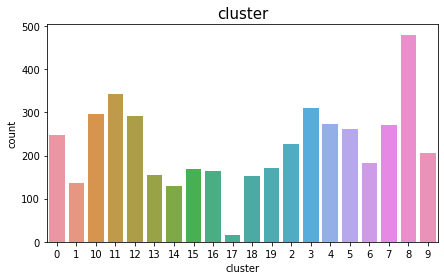

In [24]:

clusters_number = 20
kmeans = KMeans(n_clusters=clusters_number, random_state=0).fit(category_vecs)#,sample_weight=category_data['up_votes'].tolist())
category_data['cluster'] = pd.Series(kmeans.labels_, index=category_data.index)
data = category_data.copy()
plt.figure(figsize=(7,4))
sns.countplot(data['cluster'].astype('str').sort_values())
plt.title("cluster",fontsize=15)
plt.show()

In [25]:
key_words = {}

for cluster in range(clusters_number):
  key_words[cluster] = Counter(" ".join(category_data[category_data['cluster']==cluster]["text"]).split()).most_common(6)

for cluster, cluster_word in key_words.items():
  print(cluster, cluster_word)

0 [('nice', 56), ('amazing', 41), ('superb', 28), ('awesome', 23), ('excellent', 18), ('great', 17)]
1 [('apps', 55), ('nice', 21), ('best', 20), ('great', 19), ('new', 16), ('application', 14)]
2 [('super', 57), ('mst', 8), ('mast', 6), ('nic', 5), ('supper', 5), ('experience', 4)]
3 [('phone', 98), ('update', 91), ('video', 72), ('time', 64), ('send', 61), ('status', 61)]
4 [('love', 78), ('😍', 36), ('best', 27), ('loved', 26), ('♡', 20), ('😘', 18)]
5 [('nice', 275), ('wow', 4), ('gud', 3), ('excellent', 3), ('v', 2), ('👍', 2)]
6 [('friends', 70), ('best', 58), ('love', 45), ('family', 41), ('great', 34), ('people', 29)]
7 [('video', 88), ('use', 72), ('send', 63), ('phone', 60), ('calls', 55), ('best', 54)]
8 []
9 [('update', 29), ('application', 18), ('new', 16), ('nice', 16), ('great', 15), ('download', 15)]
10 [('ooooooooooooooo', 6), ('awsm', 5), ('great', 5), ('super', 4), ('💞', 4), ('version', 3)]
11 [('awesome', 84), ('great', 74), ('excellent', 55), ('ok', 31), ('cool', 31),

# Maintaing Keywords

In [0]:
import operator

def maintain_keywords(keywords, new_text, threshold, max_words, index):
  # members_count = keywords['members_count']
  #decay the weights for old words, to allow new concept from taking place here
  keywords.update((x , [y[0]*0.9, y[1]])for x, y in keywords.items() if (index - y[1]) >10)
  for word in new_text.split():
    if word in keywords:
      keywords[word][0]+=1
    else:
      #first index for the count of the word, the other is the index of the last occurence of the word
      keywords[word] = [0,0]
      keywords[word][0]=1
    keywords[word][1] = index

      
  if len(keywords) > max_words:
    sorted_key_words = sorted(keywords,key=lambda k: keywords[k][0], reverse=True)
    # print(keywords)
    # print(sorted_key_words)
    for i in range(max_words-1,len(keywords)):
      keywords.pop(sorted_key_words[i])
  return keywords






# Streaming KMeans

In [0]:
def update_keywords(keywords, data, new_labels, k, index, keywords_size):
  new_keywords = keywords.copy()
  #initialize the keywords for the first time
  if len(keywords) == 0:
    for i in range(k):
      new_keywords[i] = {}
      keywords[i] = {}
  for i in range(k):
    if new_labels[i] in new_keywords:
      new_keywords[new_labels[i]] = {**keywords[i], **new_keywords[new_labels[i]]}  
    else: 
      new_keywords[new_labels[i]] = keywords[i]
  for i in range(k):
    if i not in new_keywords:
      new_keywords[i] = {}
  keywords = None

  #skip first k elements as they are the old centers
  for i, label in enumerate(new_labels[k:]):
    new_keywords[label] = maintain_keywords(new_keywords[label], data[i], 0, keywords_size, index)
    
    index+=1
  return new_keywords




def get_k_means_weights(old_weights, labels):
    weights = []
    unique, counts = np.unique(labels, return_counts=True)
    for i in unique:
        weights.append(counts[i])

    '''update with old_weights, by iterating through the first k points which are the old centers'''
    for i in range(len(weights)):
        weights[labels[i]]+=old_weights[i]

    return weights

def stream_k_means(stream, data, k, keywords_size, buffer_size = 16):
    keywords = {}
    index = 0
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(stream[:buffer_size])
    centers = kmeans.cluster_centers_
    old_weights = [1] * k
    weights = get_k_means_weights(old_weights,kmeans.labels_)
    for i in range(1, int(len(stream)/buffer_size+1)):
        batch = np.append(centers, stream[i*buffer_size: (i+1)* buffer_size], axis=0)
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(batch, sample_weight= weights + [1]* (len(batch) -k))
        centers = kmeans.cluster_centers_
        weights = get_k_means_weights(weights, kmeans.labels_)
        if data!=None:
          keywords = update_keywords(keywords, data[i*buffer_size: (i+1)* buffer_size], kmeans.labels_, k, index, keywords_size)
          index+=buffer_size

    return centers, weights, keywords

# LEADER

In [0]:


def keep_cos(vecs, new_vec, threshold):
    max_sim = 0
    matching_index = -1
    for i, vec in enumerate(vecs):
        sim = np.corrcoef(new_vec, vec)[1, 0]
        # sim = np.dot(new_vec, vec) / (np.norm(new_vec) * np.norm(vec))
        if sim > max_sim:
            max_sim = sim
            matching_index = i

    if max_sim > threshold:
        return matching_index , max_sim

    return -1, 1

def keep_euc(vecs, new_vec, threshold):
    max_sim = 9999
    matching_index = -1
    for i, vec in enumerate(vecs):
        sim = np.linalg.norm(new_vec - vec)
        if sim < max_sim:
            max_sim = sim
            matching_index = i
    if max_sim < threshold:
        return matching_index , max_sim

    return -1, 1

def leader(stream, data, threshold, method = 'cos'):
    keywords = {}
    centers = [stream[0]]
    for x in stream:
        if method =='cos':
            matching_index, max_sim = keep_cos(centers, x, threshold=threshold)
        else:
            matching_index, max_sim = keep_euc(centers, x, threshold=threshold)
        if matching_index == -1:
            centers.append(np.array(x))

    return np.array(centers)

def edited_leader(stream, data, threshold, keywords_num, method = 'cos'):
    keywords = {}
    centers = []
    count = []
    for i, x in enumerate(stream):
        if method == 'cos':
            matching_index, max_sim = keep_cos(centers, x, threshold=threshold)
        else:
            matching_index, max_sim = keep_euc(centers, x, threshold=threshold)
        if matching_index == -1:
            centers.append(np.array(x))
            count.append(1)
            if data is not None:
              keywords[len(count)-1] = {}
              keywords[len(count)-1] = maintain_keywords(keywords[len(count)-1], data[i], 0, keywords_num, i)
        else:
            old_center = centers[matching_index]
            weight = count[matching_index]
            if data is not None:
              count[matching_index]+=1
              new_center = (weight*old_center + x) / (weight+1)
              centers[matching_index] = new_center
              keywords[matching_index] = maintain_keywords(keywords[matching_index], data[i], 0, keywords_num, i)


    return np.array(centers), count, keywords

# Simple comparison

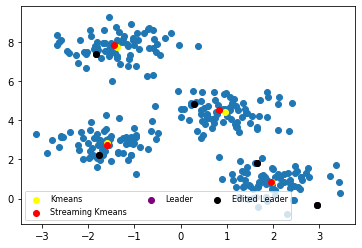

In [44]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
np.random.shuffle(X)

'''get centers'''
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)
centers, weights, keywords = stream_k_means(stream = X ,data = None, k = 4, keywords_size = 0)
leader_centers = leader(stream = X,data = None,threshold= 2.5,method= 'euc')
edited_leader_centers, weights, keywords = edited_leader(stream = X, data = None, threshold= 2.5, keywords_num=0, method= 'euc')
# leader_centers = leader(X, 0.9, 'cos')


plt.scatter(X[:, 0], X[:, 1])
kmeans_plot = plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='yellow', label = 'kmeans')

s_kmeans_plot = plt.scatter(centers[:, 0], centers[:, 1], color='red', label = 'streaming kmeans')
leader_plot = plt.scatter(leader_centers[:, 0], leader_centers[:, 1], color='purple', label = 'leader')
ed_leader_plot = plt.scatter(edited_leader_centers[:, 0], edited_leader_centers[:, 1], color='black', label = 'edited leader')
plt.legend((kmeans_plot, s_kmeans_plot, leader_plot, ed_leader_plot),
           ('Kmeans', 'Streaming Kmeans', 'Leader', 'Edited Leader'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()

# K-Means key words

# Feature suggestion reviews

In [0]:
clusters_number = 10
keywords_size = 10
kmeans_centers, weights, kmeans_keywords = stream_k_means(category_vecs, category_data_text, clusters_number, keywords_size, 32)
print(weights)

[22, 565, 9, 4, 2, 2, 1, 13, 3, 1]


In [0]:
plt.bar(range(len(weights)),weights)

In [0]:
kmeans_keywords

In [0]:
for k, v in kmeans_keywords.items():
  sorted_key_words = sorted(v,key=lambda h: v[h][0], reverse=True)[:10]
  print(k, sorted_key_words)

0 ['message', 'phone', 'option', 'add', 'great', 'time', 'update', 'chat', 'u', 'videos']
1 ['option', 'message', 'people', 'chat', 'add', 'time', 'group', 'phone', 'notifications']
2 ['group', 'option', 'great', 'chat', 'status', 'number', 'update', 'people', 'video']
3 ['option', 'chat', 'add', 'group', 'status', 'number', 'great', 'online', 'ringtone']
4 ['chat', 'option', 'group', 'message', 'status', 'plz', 'time', 'great', 'people']
5 ['group', 'chat', 'people', 'status', 'add', 'option', 'great', 'u', 'online', 'sir']
6 ['message', 'phone', 'great', 'time', 'update', 'option', 'add', 'chat', 'whtsaap']
7 ['people', 'status', 'time', 'great', 'group', 'chat', 'u', 'update', 'add', 'online']
8 ['group', 'people', 'update', 'option', 'status', 'chat', 'powerful', 'looking', 'clients']
9 ['people', 'group', 'status', 'add', 'u', 'sir', 'need', '5peole', 'great']


# All whatsapp reviews

[3, 19, 2141, 620, 5, 4, 16, 1262, 1815, 5]


<BarContainer object of 10 artists>

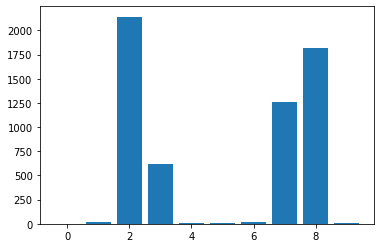

In [32]:
clusters_number = 10
keywords_size = 100
kmeans_centers, weights, kmeans_keywords = stream_k_means(category_vecs, category_data_text, clusters_number, keywords_size, 32)
print(weights)
plt.bar(range(len(weights)),weights)

In [33]:
for k, v in kmeans_keywords.items():
  sorted_key_words = sorted(v,key=lambda h: v[h][0], reverse=True)[:10]
  print(k, sorted_key_words)

0 ['thank', 'fixing', 'love', 'message', 'working', 'usefull', 'feature', 'description', 'happens', 'voice']
1 ['quality', 'people', 'chat', 'usefull', 'calling', 'pls', 'feature', 'update', 'recently', 'profile']
2 ['awesome', 'nice', 'fixing', 'group', 'great', 'feature', 'usefull', 'status', 'description', 'happens']
3 ['love', 'service', 'usefull', 'great', 'phone', 'message', 'excellent', 'community', 'lots', 'ok']
4 ['quality', 'people', 'apps', 'backup', 'chats', 'phone', 'needs', 'number', 'option', 'day']
5 ['usefull', 'calling', 'pls', 'nice', 'useful', 'facilities', 'working', 'superb', 'great', 'wats']
6 ['apps', 'best', 'way', 'update', 'number', 'admins', 'person', 'day', 'know', 'touch']
7 ['admins', 'day', 'great', 'add', 'chat', 'fh', 'chats', 'status', 'remove', 'kick']
8 ['quality', 'people', 'status', 'best', 'chats', 'usefull', 'option', 'needs', 'groups', 'easy']
9 ['super', 'admins', 'day', 'nice', 'fh', 'add', 'chat', 'apps', 'chats', 'remove']


# Leader keywords

# Feature suggestion reviews

102


<BarContainer object of 102 artists>

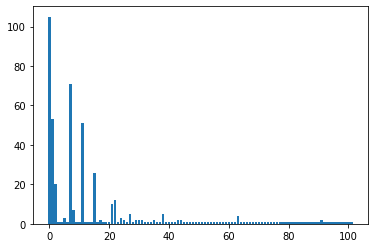

In [0]:
threshold = 0.6
keywords_num = 100
leader_centers, count, keywords = edited_leader(category_vecs, category_data_text, threshold, keywords_num, 'cos')
print(len(leader_centers))
plt.bar(range(len(count)),count)

In [0]:

for k, v in keywords.items():
  sorted_key_words = sorted(v,key=lambda h: v[h][0], reverse=True)
  if len(sorted_key_words) > 90:
    print(k, sorted_key_words[:10])

0 ['group', 'groups', 'option', 'number', 'status', 'video', 'send', 'people', 'time', 'able']
1 ['status', 'video', 'option', 'update', 'feature', 'videos', 'audio', 'add', 'picture', 'share']
2 ['message', 'delete', 'deleted', 'option', 'status', 'messages', 'mistake', 'chat', 'edit', 'spam']
7 ['chat', 'feature', 'plz', 'add', 'option', 'group', 'people', 'look', 'update', 'online']
11 ['message', 'messages', 'sending', 'option', 'status', 'time', 'notifications', 'feature', 'notification', 'update']
15 ['group', 'groups', 'add', 'admin', 'members', 'option', 'delete', 'feature', 'admins', 'time']
21 ['mode', 'dark', 'night', 'use', 'option', 'daily', 'great', 'feature', 'tone', 'issue']
22 ['update', 'sir', 'security', 'need', 'phone', '5peole', 'n', 'send', 'people', 'request']


# All whatsapp reviews

55


<BarContainer object of 55 artists>

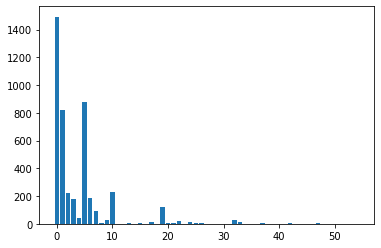

In [42]:
threshold = 0.7
keywords_num = 100
leader_centers, count, keywords = edited_leader(category_vecs, category_data_text, threshold, keywords_num, 'cos')
print(len(leader_centers))
plt.bar(range(len(count)),count)

In [41]:
#0.7
for k, v in keywords.items():
  sorted_key_words = sorted(v,key=lambda h: v[h][0], reverse=True)
  if len(sorted_key_words) > 90:
    print(k, sorted_key_words[:10])

3 ['raj', 'patel', 'jeet', 'neha', 'pandey', 'ranjeet', 'prasanth', 'bala', 'shivam', 'jadi']
5 ['video', 'status', 'update', 'record', 'section', 'voice', 'videos', 'seconds', 'times', 'media']
10 ['best', 'chats', 'way', 'friends', 'group', 'calling', 'phone', 'free', 'videos', 'touch']
11 ['feature', 'option', 'message', 'status', 'add', 'chat', 'update', 'disturb', 'calls', 'messages']
15 ['sreya', 'kukku', 'amaizing', 'nad', 'akcha', 'veery', 'goods', 'trueoflife', 'anji', 'df']
21 ['nice', 'awsm', 'super', 'harshit', 'purohit', 'superrrrrrrrrrrrrrrrb', 'awsme', 'mukhiya', 'mynewapp', 'supar']
26 ['message', 'notification', 'update', 'android', 'version', 'new', 'time', 'feature', 'issue', 'alex']
35 ['status', 'option', 'people', 'feature', 'privacy', 'picture', 'friends', 'profile', 'suggestion', 'add']
37 ['phone', 'calls', 'message', 'notification', 'issue', 'earphones', 'work', 'update', 'working', 'screen']
38 ['backup', 'chats', 'send', 'phone', 'able', 'photo', 'photos', '

# Word Level

In [0]:
# 2. download google word2vec pretrained embedding 
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
!pip install gensim
from gensim.models import KeyedVectors
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [0]:
word2vec.word_vec("test")[:10]

In [0]:
words = []
words_vecs = []
for text in category_data_text:
  for word in text.split():
    if word in word2vec.wv.vocab:
      words.append(word)
      words_vecs.append(word2vec.word_vec(word))
print(len(words))

8269


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


214


<BarContainer object of 214 artists>

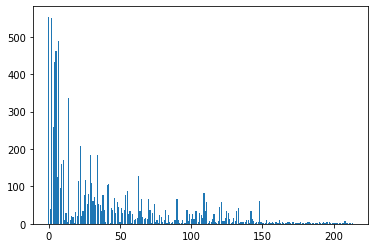

In [0]:
threshold = 0.3
keywords_num = 100
leader_centers, count, keywords = edited_leader(words_vecs, words, threshold, keywords_num, 'cos')
print(len(leader_centers))
plt.bar(range(len(count)),count)

In [0]:
for k, v in keywords.items():
  sorted_key_words = sorted(v,key=lambda h: v[h][0], reverse=True)[:10]
  if len(sorted_key_words) == 10:
    print(k, sorted_key_words)

0 ['option', 'need', 'allow', 'use', 'available', 'useful', 'options', 'easier', 'easy', 'possible']
1 ['data', 'files', 'material', 'archive', 'information', 'documents', 'document', 'informations', 'tracking', 'databases']
2 ['amazing', 'best', 'love', 'great', 'thing', 'guys', 'hard', 'excellent', 'real', 'difficult']
3 ['add', 'feature', 'features', 'include', 'highlight', 'included', 'addition', 'plus', 'contains', 'consisting']
4 ['sure', 'know', 'look', 'tell', 'dislike', 'hope', 'happened', 'think', 'thank', 'recommend']
5 ['update', 'chat', 'video', 'download', 'online', 'chats', 'chatting', 'web', 'videos', 'updates']
7 ['plz', 'wa', 'hi', 'msg', 'ise', 'dev', 'automaticaly', 'r', 'wo', 'thankyou']
9 ['photos', 'picture', 'photo', 'pictures', 'viewing', 'camera', 'display', 'screen', 'zoom', 'images']
10 ['people', 'participants', 'person', 'politicians', 'individuals', 'viewers', 'peole', 'girls', 'persons', 'residents']
14 ['notifications', 'users', 'delete', 'deleted', 'bu